# Understanding Impact of a Behaviourally-Optimised Call Script on Customer Perceptions

In [ ]:
# Load packages

from nlp import obtain_corpus, normalise_corpus, lda_topicmodel, plot_all_topics_grid, match_themes_from_corpus
import pandas as pd
from sentiment import analyse_sentiment_textblob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from clean_task2 import exclude_february, data_segmentation, parse_date_safe
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Data Cleaning

In [ ]:
# Load data
df_control = pd.read_excel('../data_source/CDS_25_Task2.xlsx', 'C Control')
df_treatment = pd.read_excel('../data_source/CDS_25_Task2.xlsx', 'C Pilot')
print(df_treatment['TO_CHAR'].unique())
# Exclude February data
df_control = exclude_february(df_control)
df_treatment['TO_CHAR'] = df_treatment['TO_CHAR'].astype(str).str.replace(r'(?i)company', '02', regex=True)
df_treatment['TO_CHAR'] = df_treatment['TO_CHAR'].apply(parse_date_safe)
df_treatment = exclude_february(df_treatment)

[datetime.datetime(2023, 2, 1, 0, 0) '01/03/2company3' '01/04/2company3'
 '01/05/2company3' '01/06/2company3']


In [14]:
# Combine dataframes
df_combined = pd.concat([df_control, df_treatment], ignore_index=True)
# Segment the dataset into VOLT, non-VOLT, and their respective control and treatment groups
df_v, df_nv, df_v_control, df_nv_control, df_v_treatment, df_nv_treatment = data_segmentation(df_combined)

### Topic Modelling & Theme Discovery

In [15]:
# Load Corpus' to Analyse

general_corpus = obtain_corpus(df_combined)
general_corpus = normalise_corpus(general_corpus)

control_corpus = obtain_corpus(df_control)
control_corpus = normalise_corpus(control_corpus)

treatment_corpus = obtain_corpus(df_treatment)
treatment_corpus = normalise_corpus(treatment_corpus)

volt_corpus = obtain_corpus(df_v)
volt_corpus = normalise_corpus(volt_corpus)

nonvolt_corpus = obtain_corpus(df_nv)
nonvolt_corpus = normalise_corpus(nonvolt_corpus)

In [16]:
# General Corpus Topic Modelling

lda_general, general_matrix, general_features = lda_topicmodel(general_corpus, 10)

Topic #1 with weights
[(np.str_('knowledgeable'), 1.18), (np.str_('introduce'), 0.73), (np.str_('interne'), 0.73), (np.str_('mislead'), 0.72), (np.str_('etc'), 0.7), (np.str_('50'), 0.7), (np.str_('conversation'), 0.69), (np.str_('friend'), 0.67)]
Topic #2 with weights
[(np.str_('well'), 2.97), (np.str_('sort'), 1.65), (np.str_('everything'), 1.45), (np.str_('explain'), 1.32), (np.str_('easily'), 1.31), (np.str_('problem'), 1.02), (np.str_('percy'), 1.02), (np.str_('login'), 0.96)]
Topic #3 with weights
[(np.str_('service'), 33.39), (np.str_('good'), 22.62), (np.str_('customer'), 16.76), (np.str_('great'), 13.88), (np.str_('excellent'), 11.87), (np.str_('helpful'), 10.5), (np.str_('easy'), 10.09), (np.str_('get'), 9.32)]
Topic #4 with weights
[(np.str_('prompt'), 3.06), (np.str_('response'), 2.42), (np.str_('complete'), 1.09), (np.str_('service'), 1.03), (np.str_('awful'), 1.0), (np.str_('delivery'), 0.97), (np.str_('enter'), 0.94), (np.str_('good'), 0.92)]
Topic #5 with weights
[(np.s

/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymon

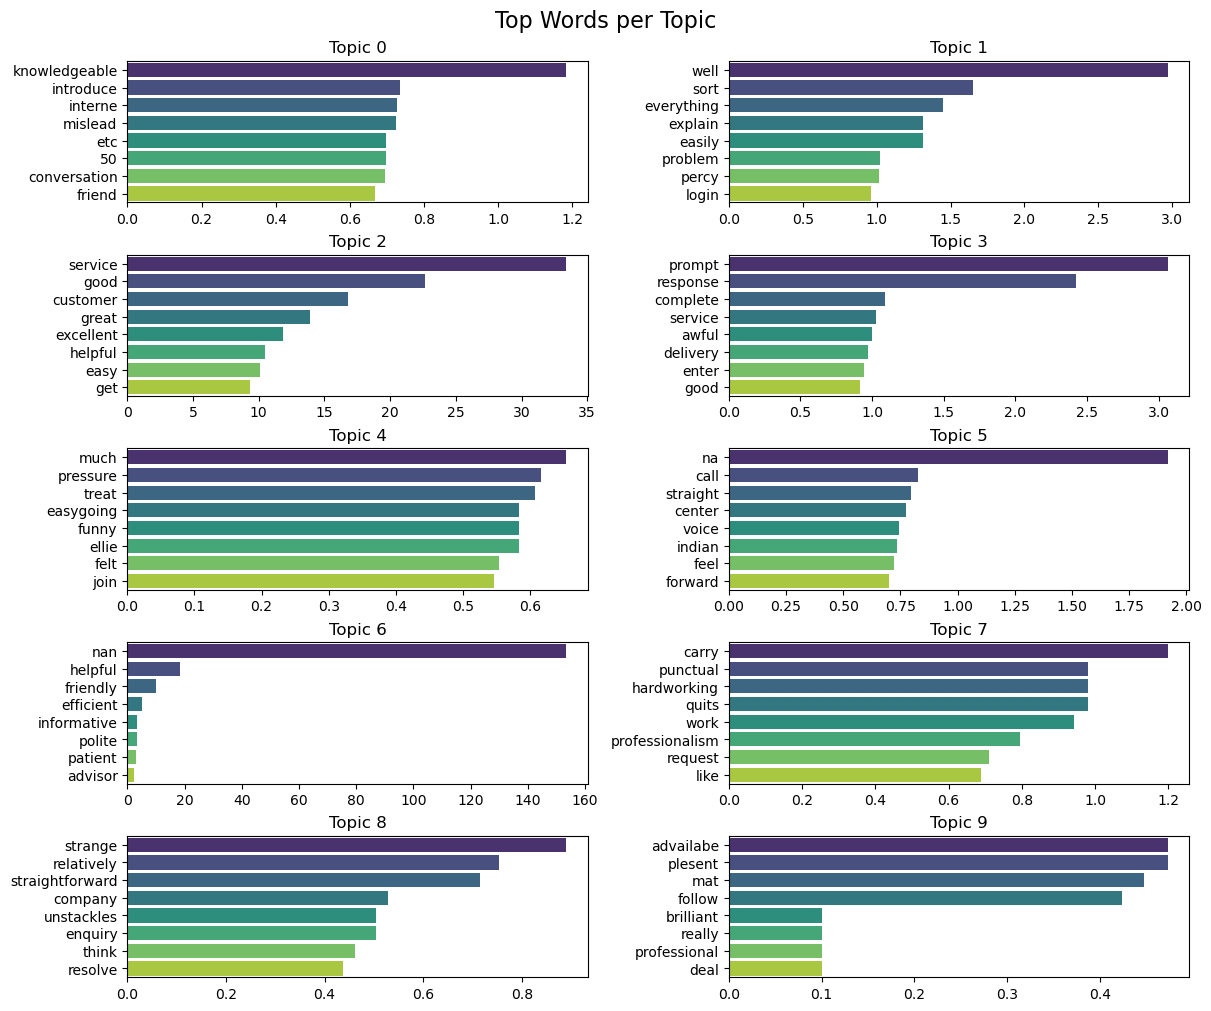

In [17]:
plot_all_topics_grid(lda_general, general_features)

In [18]:
# Treatment Corpus Topic Modelling
lda_treatment, treatment_matrix, treatment_features = lda_topicmodel(treatment_corpus, 10)

Topic #1 with weights
[(np.str_('nan'), 67.58), (np.str_('helpful'), 1.98), (np.str_('phone'), 1.76), (np.str_('speak'), 1.71), (np.str_('support'), 0.97), (np.str_('query'), 0.85), (np.str_('lady'), 0.8), (np.str_('adam'), 0.79)]
Topic #2 with weights
[(np.str_('helpful'), 10.98), (np.str_('friendly'), 7.67), (np.str_('efficient'), 3.74), (np.str_('well'), 3.12), (np.str_('everything'), 3.1), (np.str_('explain'), 3.02), (np.str_('staff'), 2.57), (np.str_('extremely'), 2.07)]
Topic #3 with weights
[(np.str_('service'), 12.2), (np.str_('good'), 6.25), (np.str_('customer'), 6.16), (np.str_('great'), 5.7), (np.str_('price'), 4.02), (np.str_('company'), 3.2), (np.str_('excellent'), 3.11), (np.str_('get'), 2.13)]
Topic #4 with weights
[(np.str_('professionalism'), 0.81), (np.str_('like'), 0.74), (np.str_('percy'), 0.62), (np.str_('start'), 0.38), (np.str_('mark'), 0.38), (np.str_('top'), 0.38), (np.str_('listen'), 0.38), (np.str_('understood'), 0.38)]
Topic #5 with weights
[(np.str_('sort')

/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymon

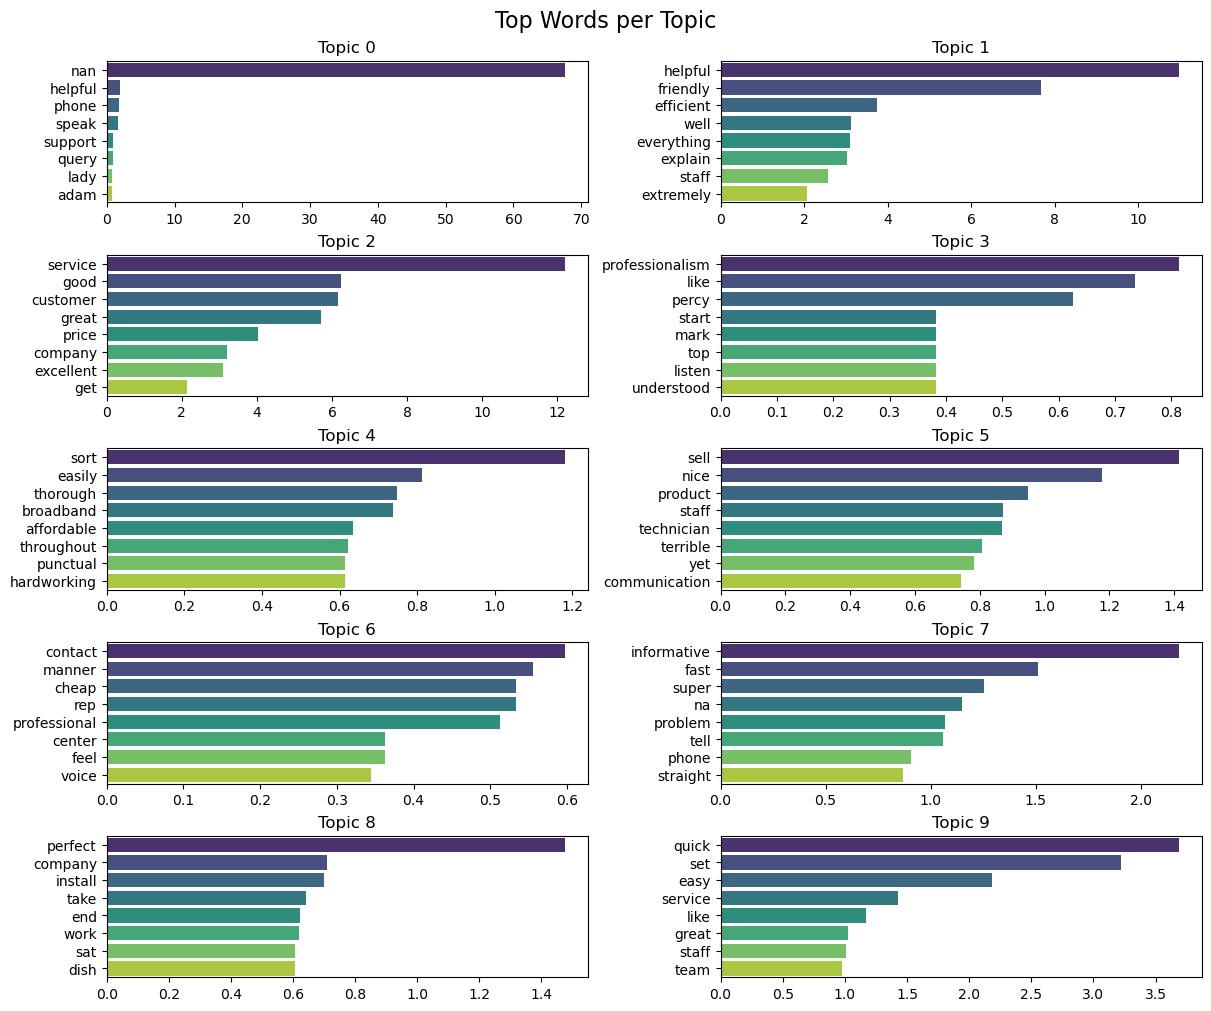

In [19]:
plot_all_topics_grid(lda_treatment, treatment_features)

In [20]:
# Control Corpus Topic Modelling
lda_control, control_matrix, control_features = lda_topicmodel(control_corpus, 10)

Topic #1 with weights
[(np.str_('nice'), 1.15), (np.str_('funny'), 0.85), (np.str_('ellie'), 0.85), (np.str_('easygoing'), 0.85), (np.str_('aswell'), 0.62), (np.str_('pleasent'), 0.62), (np.str_('thanks'), 0.33), (np.str_('steph'), 0.33)]
Topic #2 with weights
[(np.str_('excellent'), 8.02), (np.str_('service'), 4.98), (np.str_('customer'), 3.47), (np.str_('broadband'), 1.93), (np.str_('technician'), 1.3), (np.str_('somebody'), 1.06), (np.str_('package'), 1.0), (np.str_('thing'), 0.94)]
Topic #3 with weights
[(np.str_('wrong'), 0.69), (np.str_('message'), 0.65), (np.str_('two'), 0.61), (np.str_('what'), 0.59), (np.str_('ap'), 0.59), (np.str_('hasn'), 0.59), (np.str_('completely'), 0.59), (np.str_('totally'), 0.59)]
Topic #4 with weights
[(np.str_('call'), 1.41), (np.str_('well'), 0.76), (np.str_('would'), 0.76), (np.str_('later'), 0.75), (np.str_('relatively'), 0.74), (np.str_('add'), 0.72), (np.str_('straightforward'), 0.7), (np.str_('indian'), 0.69)]
Topic #5 with weights
[(np.str_('i

/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymon

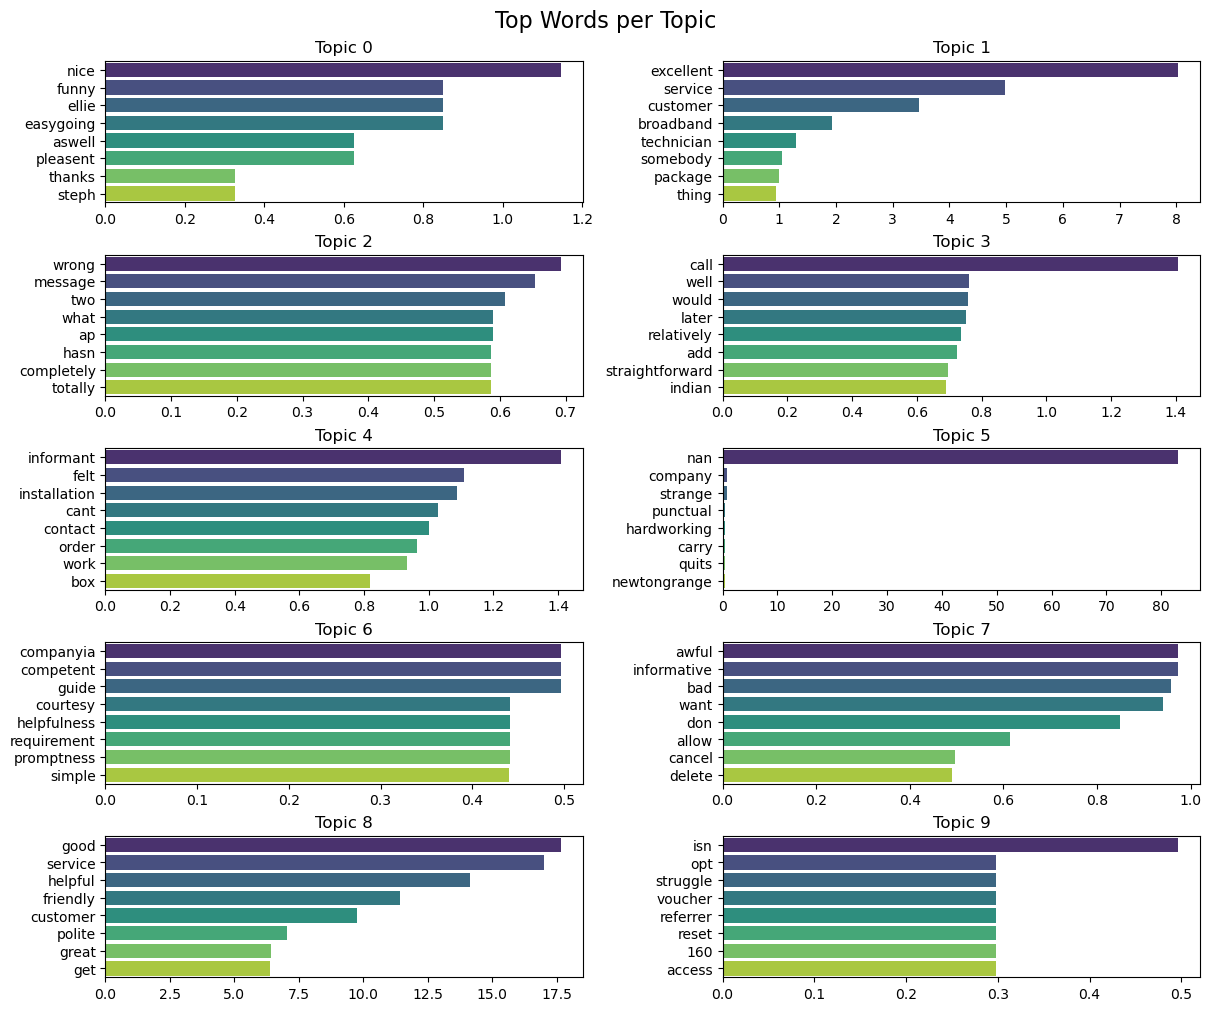

In [21]:
plot_all_topics_grid(lda_control, control_features)

In [22]:
# Zero-Shot Theme Extraction

model = SentenceTransformer('all-MiniLM-L6-v2')
themes = ["agent personality", "clarity", "reassurance"]
theme_embeddings = model.encode(themes, convert_to_tensor=True)

# General_corpus
df_results, theme_counts = match_themes_from_corpus(general_corpus, model, themes, theme_embeddings)

print(df_results)
print("\nTheme percentages:")
print(theme_counts)


                                               comment      matched_theme  \
0                                         good package        reassurance   
1                                good customer service        reassurance   
2    far good charlie efficient helpful let¬ hope c...        reassurance   
3                                  great communication            clarity   
4                chris amaze contact put detail online        reassurance   
..                                                 ...                ...   
577                                          efficient            clarity   
578                                helpful informative            clarity   
579  gentleman deal us helpful friendly deserve lot...  agent personality   
580                                                nan            clarity   
581  really easy get deal want really friendly staf...  agent personality   

     confidence  
0         0.262  
1         0.203  
2         0.253  
3  

In [23]:
# Treatment_corpus
df_results, theme_counts = match_themes_from_corpus(treatment_corpus, model, themes, theme_embeddings)

print(df_results)
print("\nTheme percentages:")
print(theme_counts)

                                               comment      matched_theme  \
0                                                  nan            clarity   
1                                                  nan            clarity   
2                                                  nan            clarity   
3                                                  nan            clarity   
4                                       prompt service  agent personality   
..                                                 ...                ...   
242                                          efficient            clarity   
243                                helpful informative            clarity   
244  gentleman deal us helpful friendly deserve lot...  agent personality   
245                                                nan            clarity   
246  really easy get deal want really friendly staf...  agent personality   

     confidence  
0         0.189  
1         0.189  
2         0.189  
3  

In [24]:
# Control_corpus
df_results, theme_counts = match_themes_from_corpus(control_corpus, model, themes, theme_embeddings)

print(df_results)
print("\nTheme percentages:")
print(theme_counts)

                                               comment matched_theme  \
0                                         good package   reassurance   
1                                good customer service   reassurance   
2    far good charlie efficient helpful let¬ hope c...   reassurance   
3                                  great communication       clarity   
4                chris amaze contact put detail online   reassurance   
..                                                 ...           ...   
330  helpful efficient service competitive broadban...       clarity   
331  terrible customer service week later wifi stil...   reassurance   
332  good customer service agent find us really goo...       clarity   
333                                                nan       clarity   
334  reson one emplyee rosie help go extra mile pho...   reassurance   

     confidence  
0         0.262  
1         0.203  
2         0.253  
3         0.379  
4         0.107  
..          ...  
330      

### Sentiment Analysis

In [67]:
def run_sentiment_pipeline(corpus):
    valid_docs = [(i, doc) for i, doc in enumerate(corpus) if isinstance(doc, str) and doc.strip()]
    valid_indices = [i for i, _ in valid_docs]
    filtered_corpus = [doc for _, doc in valid_docs]
    sentiment_results = [analyse_sentiment_textblob(doc, verbose=False) for doc in filtered_corpus]
    sentiment_labels, polarities, subjectivities = zip(*sentiment_results)
    sentiment_df = pd.DataFrame({
        'index': valid_indices,
        'document': filtered_corpus,
        'sentiment_label': sentiment_labels,
        'polarity': polarities,
        'subjectivity': subjectivities
    }).set_index('index').sort_index()
    return sentiment_df, valid_indices

In [68]:
sentiment_df, valid_indices = run_sentiment_pipeline(general_corpus)
sentiment_treatment, treatment_indices = run_sentiment_pipeline(treatment_corpus)
sentiment_control, control_indices = run_sentiment_pipeline(control_corpus)
sentiment_volt, _ = run_sentiment_pipeline(volt_corpus)

In [ ]:
# # Filter for non-empty documents
# valid_docs = [(i, doc) for i, doc in enumerate(general_corpus) if isinstance(doc, str) and doc.strip()]
# valid_indices = [i for i, _ in valid_docs]
# filtered_corpus = [doc for _, doc in valid_docs]

In [ ]:
# # Sentiment Analysis for General Corpus

# sentiment_results = [analyse_sentiment_textblob(doc, verbose=False) for doc in filtered_corpus]
# sentiment_labels, polarities, subjectivities = zip(*sentiment_results)
# sentiment_df = pd.DataFrame({
#     'index': valid_indices,
#     'document': filtered_corpus,
#     'sentiment_label': sentiment_labels,
#     'polarity': polarities,
#     'subjectivity': subjectivities
# }).set_index('index').sort_index()
# print(sentiment_df.head())
# # sentiment_df.to_csv('../data_source/sentiment_analysis_results.csv', index=False)

                                                document sentiment_label  \
index                                                                      
0                                           good package        positive   
1                                  good customer service        positive   
2      far good charlie efficient helpful let¬ hope c...        positive   
3                                    great communication        positive   
4                  chris amaze contact put detail online        negative   

       polarity  subjectivity  
index                          
0          0.70          0.60  
1          0.70          0.60  
2          0.43          0.81  
3          0.80          0.75  
4          0.00          0.00  


In [ ]:
# # Filter for non-empty treatment documents
# valid_docs = [(i, doc) for i, doc in enumerate(treatment_corpus) if isinstance(doc, str) and doc.strip()]
# valid_indices = [i for i, _ in valid_docs]
# filtered_treatment_corpus = [doc for _, doc in valid_docs]

In [ ]:
# # Sentiment scores for treatment
# sentiment_results = [analyse_sentiment_textblob(doc, verbose=False) for doc in filtered_treatment_corpus]
# sentiment_labels, polarities, subjectivities = zip(*sentiment_results)
# sentiment_treatment = pd.DataFrame({
#     'index': valid_indices,
#     'document': filtered_treatment_corpus,
#     'sentiment_label': sentiment_labels,
#     'polarity': polarities,
#     'subjectivity': subjectivities
# }).set_index('index').sort_index()
# sentiment_treatment

,document,sentiment_label,polarity,subjectivity
index,,,,
0,nan,negative,0.00,0.00
1,nan,negative,0.00,0.00
2,nan,negative,0.00,0.00
3,nan,negative,0.00,0.00
4,prompt service,negative,0.00,0.00
...,...,...,...,...
242,efficient,negative,0.00,0.00
243,helpful informative,negative,0.00,0.00
244,gentleman deal us helpful friendly deserve lot...,positive,0.49,0.75


In [ ]:
# valid_docs = [(i, doc) for i, doc in enumerate(control_corpus) if isinstance(doc, str) and doc.strip()]
# valid_indices = [i for i, _ in valid_docs]
# filtered_control_corpus = [doc for _, doc in valid_docs]

In [ ]:
# # Sentiment scores for control
# sentiment_results = [analyse_sentiment_textblob(doc, verbose=False) for doc in filtered_control_corpus]
# sentiment_labels, polarities, subjectivities = zip(*sentiment_results)
# sentiment_control = pd.DataFrame({
#     'index': valid_indices,
#     'document': filtered_control_corpus,
#     'sentiment_label': sentiment_labels,
#     'polarity': polarities,
#     'subjectivity': subjectivities
# }).set_index('index').sort_index()
# sentiment_control

,document,sentiment_label,polarity,subjectivity
index,,,,
0,good package,positive,0.70,0.60
1,good customer service,positive,0.70,0.60
2,far good charlie efficient helpful let¬ hope c...,positive,0.43,0.81
3,great communication,positive,0.80,0.75
4,chris amaze contact put detail online,negative,0.00,0.00
...,...,...,...,...
330,helpful efficient service competitive broadban...,negative,0.00,0.00
331,terrible customer service week later wifi stil...,negative,-0.50,0.50
332,good customer service agent find us really goo...,positive,0.63,0.57


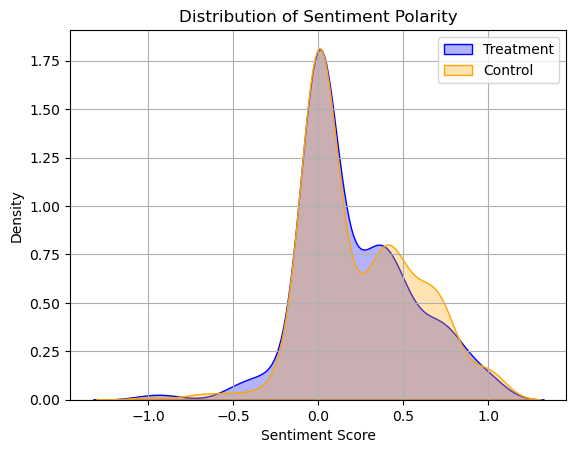

In [69]:
# Plot the sentiment distribution for treatment vs control (polarity)

sns.kdeplot(sentiment_treatment['polarity'], label='Treatment', color='blue', fill=True, alpha=0.3)
sns.kdeplot(sentiment_control['polarity'], label='Control', color='orange', fill=True, alpha=0.3)

plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Distribution of Sentiment Polarity')
plt.legend()
plt.grid(True)
plt.show()

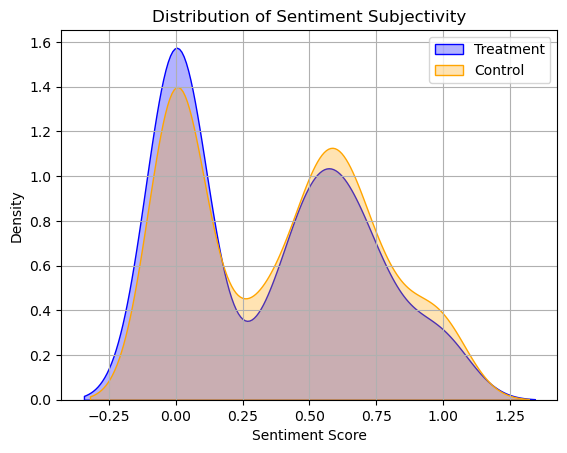

In [70]:
# Plot the sentiment distribution for treatment vs control (subjectivity)

sns.kdeplot(sentiment_treatment['subjectivity'], label='Treatment', color='blue', fill=True, alpha=0.3)
sns.kdeplot(sentiment_control['subjectivity'], label='Control', color='orange', fill=True, alpha=0.3)

plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Distribution of Sentiment Subjectivity')
plt.legend()
plt.grid(True)
plt.show()

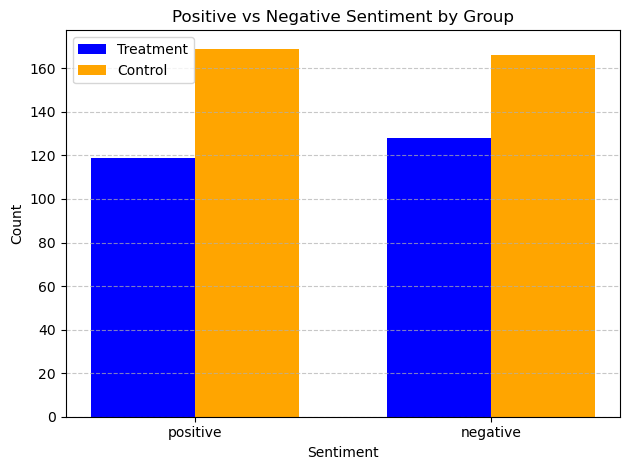

In [71]:
treatment_counts = sentiment_treatment['sentiment_label'].value_counts()
control_counts = sentiment_control['sentiment_label'].value_counts()

labels = ['positive', 'negative']
treatment_vals = [treatment_counts.get(label, 0) for label in labels]
control_vals = [control_counts.get(label, 0) for label in labels]

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, treatment_vals, width, label='Treatment', color='blue')
plt.bar(x + width/2, control_vals, width, label='Control', color='orange')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Positive vs Negative Sentiment by Group')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### VOLT vs General

In [58]:
sentiment_results = [analyse_sentiment_textblob(doc, verbose=False) for doc in volt_corpus]
sentiment_labels, polarities, subjectivities = zip(*sentiment_results)
sentiment_volt = pd.DataFrame({
    'document': volt_corpus,
    'sentiment_label': sentiment_labels,
    'polarity': polarities,
    'subjectivity': subjectivities
})
sentiment_volt

,document,sentiment_label,polarity,subjectivity
0,good customer service,positive,0.70,0.60
1,far good charlie efficient helpful let¬ hope c...,positive,0.43,0.81
2,chris amaze contact put detail online,negative,0.00,0.00
3,price bundle go 2 day place order,negative,0.00,0.00
4,simple straightforward process lot information...,positive,0.19,0.37
...,...,...,...,...
236,advisor explain everything clearly detailhe he...,positive,0.29,0.56
237,like quick response get everything,positive,0.33,0.50
238,great service engineer come next day lovely ge...,positive,0.43,0.50
239,helpful informative,negative,0.00,0.00


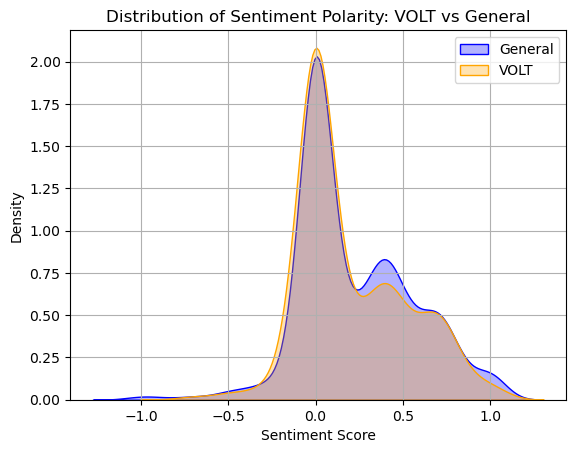

In [59]:
# Plot the sentiment distribution for VOLT vs General

sns.kdeplot(sentiment_df['polarity'], label='General', color='blue', fill=True, alpha=0.3)
sns.kdeplot(sentiment_volt['polarity'], label='VOLT', color='orange', fill=True, alpha=0.3)

plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Distribution of Sentiment Polarity: VOLT vs General')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
sentiment_df.describe()

,polarity,subjectivity
count,582.000000,582.000000
mean,0.222869,0.370206
std,0.328172,0.343995
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.075000,0.430000
75%,0.430000,0.617500
max,1.000000,1.000000


In [61]:
sentiment_volt.describe()

,polarity,subjectivity
count,241.000000,241.000000
mean,0.198921,0.354108
std,0.305988,0.349694
min,-0.700000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.400000
75%,0.410000,0.600000
max,1.000000,1.000000


#### Topics that co-occur with negative and positive sentiments

To do this, we use the original topic model and assign dominant topics to dataframes

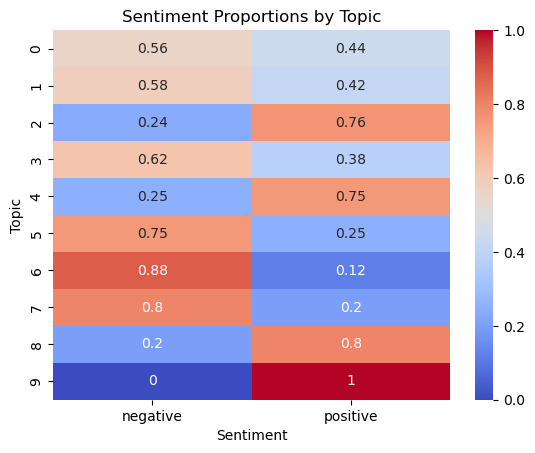

In [72]:
general_topics = lda_general.transform(general_matrix)
dominant_general = np.argmax(general_topics, axis=1)
sentiment_df['dominant_general'] = dominant_general
topic_sentiment_counts = sentiment_df.groupby(['dominant_general', 'sentiment_label']).size().unstack(fill_value=0)
topic_sentiment_props = topic_sentiment_counts.div(topic_sentiment_counts.sum(axis=1), axis=0)
sns.heatmap(topic_sentiment_props, annot=True, cmap='coolwarm')
plt.title('Sentiment Proportions by Topic')
plt.xlabel('Sentiment')
plt.ylabel('Topic')
plt.show()

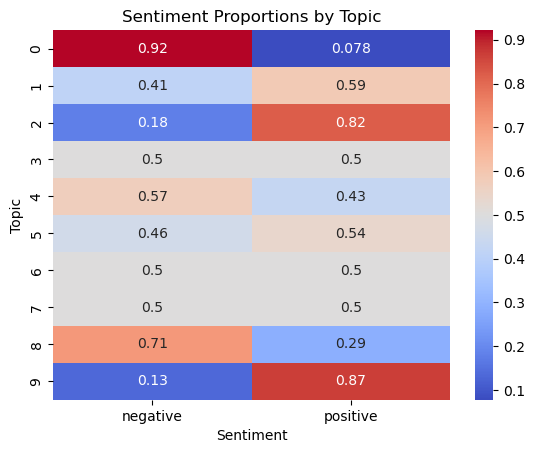

In [73]:
treatment_topics = lda_treatment.transform(treatment_matrix)
dominant_treatment = np.argmax(treatment_topics, axis=1)
sentiment_treatment['dominant_treatment'] = dominant_treatment
topic_sentiment_counts = sentiment_treatment.groupby(['dominant_treatment', 'sentiment_label']).size().unstack(fill_value=0)
topic_sentiment_props = topic_sentiment_counts.div(topic_sentiment_counts.sum(axis=1), axis=0)
sns.heatmap(topic_sentiment_props, annot=True, cmap='coolwarm')
plt.title('Sentiment Proportions by Topic')
plt.xlabel('Sentiment')
plt.ylabel('Topic')
plt.show()

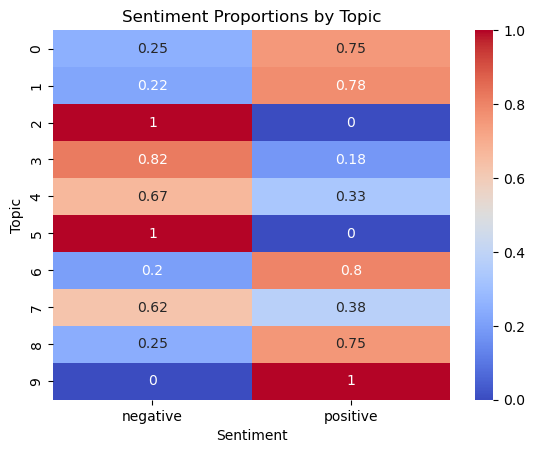

In [74]:
control_topics = lda_control.transform(control_matrix)
dominant_control = np.argmax(control_topics, axis=1)
sentiment_control['dominant_control'] = dominant_control
topic_sentiment_counts = sentiment_control.groupby(['dominant_control', 'sentiment_label']).size().unstack(fill_value=0)
topic_sentiment_props = topic_sentiment_counts.div(topic_sentiment_counts.sum(axis=1), axis=0)
sns.heatmap(topic_sentiment_props, annot=True, cmap='coolwarm')
plt.title('Sentiment Proportions by Topic')
plt.xlabel('Sentiment')
plt.ylabel('Topic')
plt.show()

### Classification Model

              precision    recall  f1-score   support

           0       0.75      0.70      0.73        61
           1       0.70      0.75      0.72        56

    accuracy                           0.73       117
   macro avg       0.73      0.73      0.73       117
weighted avg       0.73      0.73      0.73       117



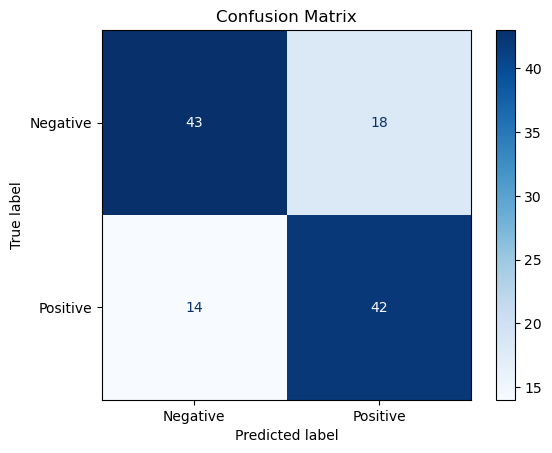

In [78]:
# Train base classification model with logistic regression
filtered_topic_distributions = general_topics[valid_indices]
binary_labels = [1 if label == 'positive' else 0 for label in sentiment_df['sentiment_label']]
X_train, X_test, y_train, y_test = train_test_split(filtered_topic_distributions, binary_labels, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [79]:
topic_names = [f"Topic {i}" for i in range(filtered_topic_distributions.shape[1])]
coefs = clf.coef_[0]

coef_df = pd.DataFrame({
    'Topic': topic_names,
    'Coefficient': coefs
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)

     Topic  Coefficient
2  Topic 2     2.639278
4  Topic 4     0.582378
1  Topic 1     0.459399
8  Topic 8     0.062032
0  Topic 0    -0.045017
9  Topic 9    -0.059635
5  Topic 5    -0.483776
7  Topic 7    -0.497380
3  Topic 3    -0.986776
6  Topic 6    -1.726777


/var/folders/2p/cx67y4vd2kv480_swjmtqf040000gn/T/ipykernel_2263/4270618204.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coefficient', y='Topic', palette='coolwarm')


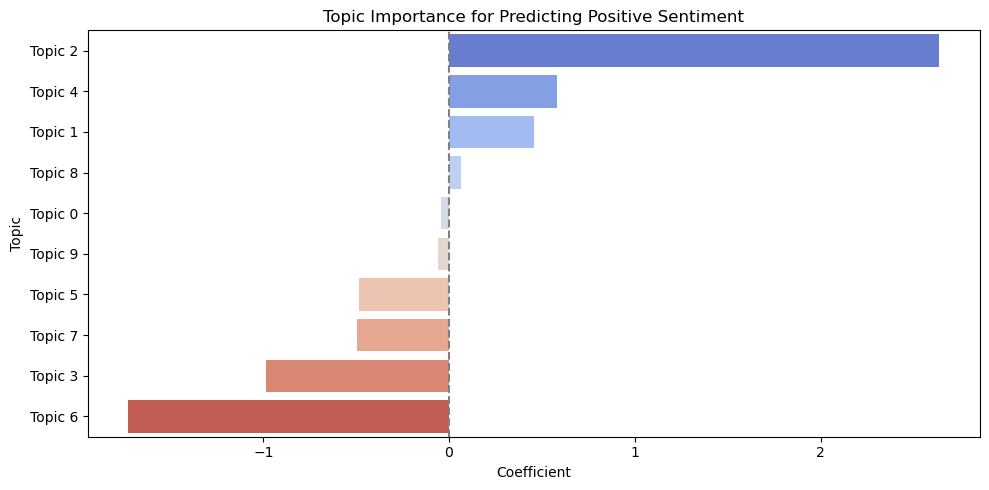

In [80]:
plt.figure(figsize=(10, 5))
sns.barplot(data=coef_df, x='Coefficient', y='Topic', palette='coolwarm')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Topic Importance for Predicting Positive Sentiment')
plt.tight_layout()
plt.show()

In [81]:
def print_top_terms_for_topic(topic_idx, top_n=10):
    topic_weights = lda_general.components_[topic_idx]
    top_indices = topic_weights.argsort()[::-1][:top_n]
    terms = [general_features[i] for i in top_indices]
    return terms

# Add to dataframe
coef_df['Top Words'] = coef_df['Topic'].apply(lambda t: print_top_terms_for_topic(int(t.split()[1])))

print(coef_df[['Topic', 'Coefficient', 'Top Words']])


     Topic  Coefficient                                          Top Words
2  Topic 2     2.639278  [service, good, customer, great, excellent, he...
4  Topic 4     0.582378  [much, pressure, treat, easygoing, funny, elli...
1  Topic 1     0.459399  [well, sort, everything, explain, easily, prob...
8  Topic 8     0.062032  [strange, relatively, straightforward, company...
0  Topic 0    -0.045017  [knowledgeable, introduce, interne, mislead, e...
9  Topic 9    -0.059635  [advailabe, plesent, mat, follow, brilliant, r...
5  Topic 5    -0.483776  [na, call, straight, center, voice, indian, fe...
7  Topic 7    -0.497380  [carry, punctual, hardworking, quits, work, pr...
3  Topic 3    -0.986776  [prompt, response, complete, service, awful, d...
6  Topic 6    -1.726777  [nan, helpful, friendly, efficient, informativ...
